Epoch 1/50


c:\Users\wlstj\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


148/148 ━━━━━━━━━━━━━━━━━━━━ 407s 3s/step - accuracy: 0.0355 - loss: 4.7205 - val_accuracy: 0.0287 - val_loss: 3.6572
Epoch 2/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 376s 3s/step - accuracy: 0.0486 - loss: 4.3062 - val_accuracy: 0.0668 - val_loss: 3.4557
Epoch 3/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 374s 3s/step - accuracy: 0.0922 - loss: 3.7363 - val_accuracy: 0.1133 - val_loss: 3.3489
Epoch 4/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 371s 2s/step - accuracy: 0.1305 - loss: 3.3640 - val_accuracy: 0.0871 - val_loss: 267.1742
Epoch 5/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 370s 2s/step - accuracy: 0.2019 - loss: 2.8625 - val_accuracy: 0.2705 - val_loss: 3.3043
Epoch 6/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 373s 3s/step - accuracy: 0.2690 - loss: 2.5477 - val_accuracy: 0.3423 - val_loss: 6.3317
Epoch 7/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 371s 2s/step - accuracy: 0.3405 - loss: 2.1810 - val_accuracy: 0.2984 - val_loss: 2.3740
Epoch 8/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 371s 2s/step - accuracy: 0.3687 - loss: 2.0764 - val_accuracy: 0.0

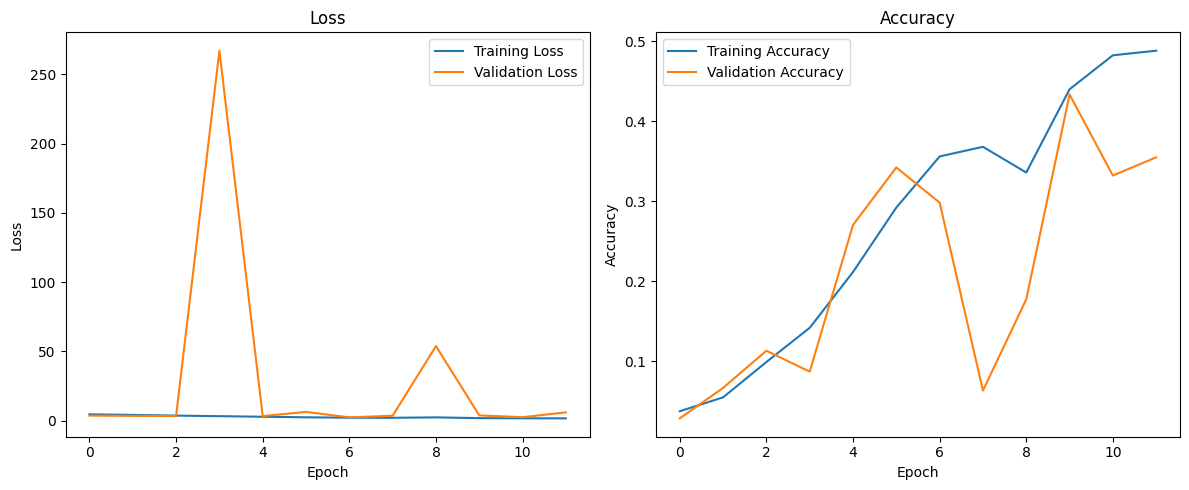

In [3]:
import os
import re
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, BatchNormalization, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split

# 이미지 디렉토리 경로 설정
input_dir = "C:/Users/wlstj/Desktop/새 폴더/2. 아이펠(aiffel)/2.개발폴더/images"

# 파일명에서 숫자만 제거하고 특수문자는 유지
def clean_label(label):
    return re.sub(r'\d+', '', label)

# 클래스 이름 추출 (파일 이름에서 클래스 추출, 숫자만 제거)
class_names = sorted(set(clean_label(fname.split('_')[0]) for fname in os.listdir(input_dir) if fname.endswith('.jpg')))
class_names_dict = {name: idx for idx, name in enumerate(class_names)}

# 데이터 증강 및 전처리 설정
datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.inception_v3.preprocess_input,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# 데이터셋 나누기
# 먼저 전체 데이터를 X와 y로 로드
input_img_paths = sorted(
    [os.path.join(input_dir, fname)
     for fname in os.listdir(input_dir)
     if fname.endswith(".jpg")]
)

images = []
labels = []

for img_path in input_img_paths:
    class_name = clean_label(os.path.basename(img_path).split('_')[0])
    class_id = class_names_dict[class_name]
    image = load_img(img_path, target_size=(299, 299))  # InceptionV3 모델의 입력 크기
    image = img_to_array(image)
    images.append(image)
    labels.append(class_id)

# Numpy 배열로 변환
images = np.array(images)
labels = np.array(labels)

# 데이터셋 나누기
X_temp, X_test, y_temp, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.2, random_state=42)

# 훈련과 검증 데이터 제너레이터 설정
train_datagen = datagen.flow(X_train, y_train, batch_size=32)
val_datagen = datagen.flow(X_val, y_val, batch_size=32)

# 모델 정의
def create_model(num_classes):
    base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(299, 299, 3))
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(2048, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(1024, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(512, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    predictions = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)
    return model

# 클래스 수 정의
num_classes = len(class_names)

# 모델 생성
model = create_model(num_classes)

# 모델 컴파일
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# 조기 종료 콜백 정의
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# 모델 훈련
history = model.fit(
    train_datagen,
    epochs=50,
    validation_data=val_datagen,
    callbacks=[early_stopping]
)

# 모델 저장
model_path = 'inceptionv3_model.h5'
model.save(model_path)

# 모델 로드 및 예측 함수
def load_and_predict(model_path, img_path):
    try:
        model = tf.keras.models.load_model(model_path, custom_objects={
            'InceptionV3': InceptionV3,
            'GlobalAveragePooling2D': GlobalAveragePooling2D,
            'Dense': Dense,
            'BatchNormalization': BatchNormalization,
            'Dropout': Dropout
        })

        img = load_img(img_path, target_size=(299, 299))
        img_array = img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array = tf.keras.applications.inception_v3.preprocess_input(img_array)

        predictions = model.predict(img_array)
        predicted_class = np.argmax(predictions, axis=1)[0]
        predicted_label = class_names[predicted_class]

        return {
            "predicted_label": predicted_label,
            "prediction_score": f"{predictions[0][predicted_class]:.5f}"
        }
    except Exception as e:
        return {"error": str(e)}

# 모델 훈련 후 history 객체에 기록된 손실 및 정확도 시각화
def plot_training_history(history):
    plt.figure(figsize=(12, 5))
    
    # 훈련 손실과 검증 손실
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # 훈련 정확도와 검증 정확도
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

# 훈련이 완료된 후 history 객체를 사용하여 시각화
plot_training_history(history)


In [4]:
import os
import re
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, BatchNormalization, Dropout
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split

# 이미지 디렉토리 경로 설정
input_dir = "C:/Users/wlstj/Desktop/새 폴더/2. 아이펠(aiffel)/2.개발폴더/images"

# 파일명에서 숫자만 제거하고 특수문자는 유지
def clean_label(label):
    return re.sub(r'\d+', '', label)

# 이미지 파일 경로 수집
input_img_paths = sorted(
    [os.path.join(input_dir, fname)
     for fname in os.listdir(input_dir)
     if fname.endswith(".jpg")]
)

# 클래스 이름 추출 (파일 이름에서 클래스 추출, 숫자만 제거)
class_names = sorted(set(clean_label(fname.split('_')[0]) for fname in os.listdir(input_dir) if fname.endswith('.jpg')))
class_names_dict = {name: idx for idx, name in enumerate(class_names)}

# 이미지와 레이블 로드
images = []
labels = []

for img_path in input_img_paths:
    class_name = clean_label(os.path.basename(img_path).split('_')[0])
    class_id = class_names_dict[class_name]
    image = load_img(img_path, target_size=(299, 299))  # InceptionV3 모델의 입력 크기
    image = img_to_array(image)
    images.append(image)
    labels.append(class_id)

# Numpy 배열로 변환
images = np.array(images)
labels = np.array(labels)

# 데이터 정규화
images = tf.keras.applications.inception_v3.preprocess_input(images)

# 데이터셋 나누기
X_temp, X_test, y_temp, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.2, random_state=42)

# 모델 정의
def create_model(num_classes):
    base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(299, 299, 3))
    
    # 모든 레이어 동결
    for layer in base_model.layers:
        layer.trainable = False

    # 마지막 몇 레이어의 동결 해제
    for layer in base_model.layers[-50:]:  # 마지막 50개 레이어의 동결 해제 예시
        layer.trainable = True

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(2048, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(1024, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(512, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    predictions = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)
    return model

# 클래스 수 정의
num_classes = len(class_names)

# 모델 생성
model = create_model(num_classes)

# 모델 컴파일
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# 조기 종료 콜백 정의
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# 모델 훈련
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping]
)

# 모델 저장
model_path = 'inceptionv3_model.h5'
model.save(model_path)

# 모델 로드 및 예측 함수
def load_and_predict(model_path, img_path):
    try:
        model = tf.keras.models.load_model(model_path, custom_objects={
            'InceptionV3': InceptionV3,
            'GlobalAveragePooling2D': GlobalAveragePooling2D,
            'Dense': Dense,
            'BatchNormalization': BatchNormalization,
            'Dropout': Dropout
        })

        img = load_img(img_path, target_size=(299, 299))
        img_array = img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array = tf.keras.applications.inception_v3.preprocess_input(img_array)

        predictions = model.predict(img_array)
        predicted_class = np.argmax(predictions, axis=1)[0]
        predicted_label = class_names[predicted_class]

        return {
            "predicted_label": predicted_label,
            "prediction_score": f"{predictions[0][predicted_class]:.5f}"
        }
    except Exception as e:
        return {"error": str(e)}

# 모델 훈련 후 history 객체에 기록된 손실 및 정확도 시각화
def plot_training_history(history):
    plt.figure(figsize=(12, 5))
    
    # 훈련 손실과 검증 손실
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # 훈련 정확도와 검증 정확도
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

# 훈련이 완료된 후 history 객체를 사용하여 시각화
plot_training_history(history)


Epoch 1/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 701ms/step - accuracy: 0.2737 - loss: 3.0317